## this data set is related to Kaggle's competition for the classification of Icebergs and ships by satellite imaging.
https://www.kaggle.com/competitions/statoil-iceberg-classifier-challenge/overview/description

In [1]:
# let's import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [9]:
data = pd.read_json("/home/pouria/train.json")
data.head(10)

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0
5,b51d18b5,"[-20.769371, -20.769434, -25.906025, -25.90602...","[-29.288746, -29.712593, -28.884804, -28.88480...",36.9034,1
6,31da1a04,"[-26.673811, -23.666162, -27.622442, -28.31768...","[-24.557735, -26.97868, -27.622442, -29.073456...",34.4751,1
7,56929c16,"[-24.989119, -27.755224, -25.817074, -24.98927...","[-27.755173, -26.732174, -28.124943, -31.83772...",41.1769,0
8,525ab75c,"[-17.146641, -17.146572, -17.994583, -19.44553...","[-25.733608, -24.472507, -24.710424, -22.77215...",35.7829,0
9,192f56eb,"[-24.020853, -23.551275, -27.18819, -29.126434...","[-28.702518, -33.563324, -29.571918, -29.12643...",43.3007,0


In [3]:
# data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB


In [5]:
#studying whether data lables are balance or not.
data['is_iceberg'].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

### let's becoming one with the data.

- ID is the ID of each satellite image.
- band_1 and band_2 are the image frequencies.
- inc_angle, Incidence angle, is the angle between the satellite and the iceberg or ship.
- see https://www.degruyter.com/document/doi/10.1515/geo-2016-0029/html?lang=en fro more information.
- is_iceberg is whether the satellite image is iceberg or ship.
- there are 1604 data points for each column without any missing data.
- the portion of the data is roughly equal to 55% to 45%. So, the data is balanced.

### let's start data visualization.

In [22]:
len(data.iloc[1][1]), len(data.iloc[1][2])
# it is the lengh of the each band.

(5625, 5625)

In [23]:
# we need to reshape this size to 75 by 75 to be able to visualize our sata.
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_1"]])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_2"]])

In [59]:
# let's define the index for ship and iceberg
ship_index = np.where(data['is_iceberg']==0)
ice_index = np.where(data['is_iceberg']==1)

In [ ]:
def plots(band,index,title):
    plt.figure(figsize=(12,10))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel((title))
        plt.imshow(np.reshape(data[band][index[0][i]], (75,75)),cmap='rainbow')
    plt.show() 

In [71]:
import random

In [78]:
# def a function to plot the image for ships and icebergs.
# this function select a band from the band_1 and nabd_2 then plot based on the index.
def plots(band,index,title):
    plt.figure(figsize=(12,10))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel((title))
        plt.imshow(np.reshape(data[band][index[0][i]], (75,75)),cmap='rainbow')
    plt.show()  

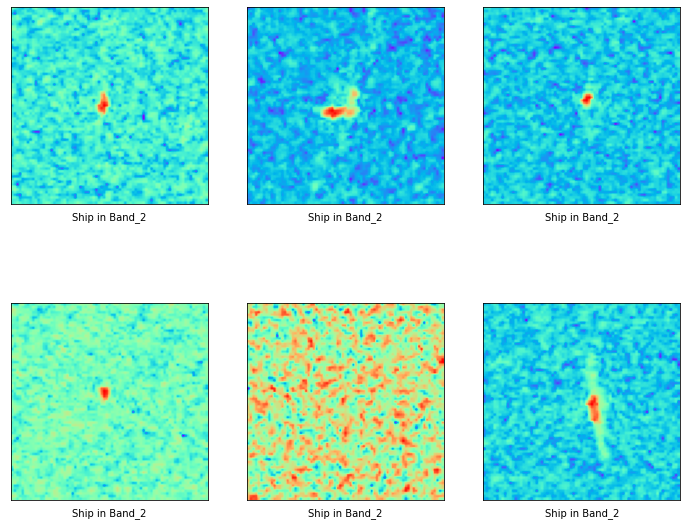

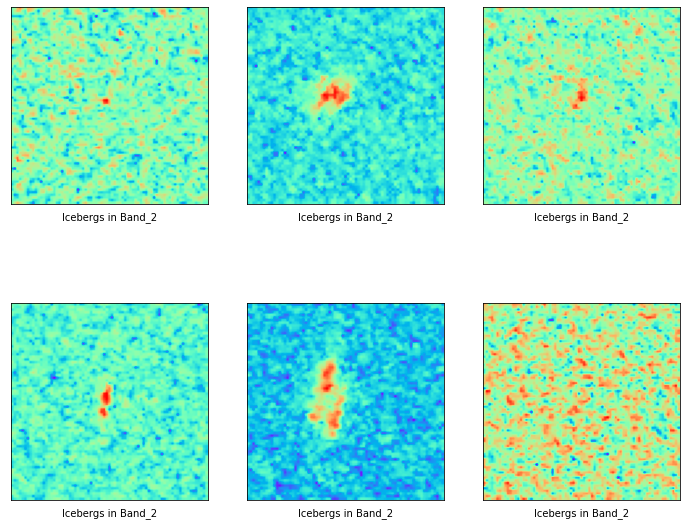

In [79]:
plots('band_2',ship_index,'Ship in Band_2'), plots('band_2', ice_index,'Icebergs in Band_2');
# it is a simple data visualization for ships and Icebergs in Band_2.

### let's plot icebergs and ships in a 3D plot.

In [91]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=25,
            r=40,
            b=65,
            t=30
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:], 'iceberg')

In [86]:
plotmy3d(X_band_1[14,:,:], 'Ship')
